# Packages Preparing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats
%matplotlib inline
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import fix_yahoo_finance as yf
import datetime
import re
import random

# Data Preparing

In [20]:
df = pd.read_csv("Data.csv")

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Columns: 503 entries, Date to ZNGA_Volume
dtypes: float64(251), int64(251), object(1)
memory usage: 1.9+ MB


# Markowitz Model

### Markowitz model is not a typically trading strategy, but we want to use it as the theoretical market performance, so that we can compare our strategies to it.

### Data preparation for Markowitz model

In [21]:
def dataproc(df):
    close = list()
    for column in df.columns:
        p = r'[a-zA-Z-]+_Close$'
        match = re.findall(p, column)
        close += match
    close = df[close]
    return close

In [22]:
close = dataproc(df)
close_1 = close.iloc[:,0:100]
close_2 = close.iloc[:,101:200]
close_3 = close.iloc[:,201:]

### Given a basket of stocks returns its weights of portfolio

In [5]:
def get_port(close, number_of_assets):
    # Initial analysis, calculate the rate of return 
    log_returns = np.log(close/close.shift(1)) 
    # To optimize the portfoio
    rets = log_returns
    year_ret = rets.mean() * 252 # calculate yearly rate of return 
    year_volatility = rets.cov() * 252 # calculate the covariance matrix
    
    portfolio_returns = []
    portfolio_volatilities = [] # create new list to store the returns and volatities calculated later
    for p in range(1000):
        weights = np.random.random(number_of_assets)
        weights /=np.sum(weights)
        portfolio_returns.append(np.sum(rets.mean() * weights) * 252)
        portfolio_volatilities.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() *252, weights))))
        
    portfolio_returns = np.array(portfolio_returns)
    portfolio_volatilities = np.array(portfolio_volatilities)
    
    # draw a scatter picture to find the point with highest sharp ratio
    plt.figure(figsize=(9,6))
    plt.scatter(portfolio_volatilities, portfolio_returns, c=portfolio_returns/portfolio_volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('expected volatility')
    plt.ylabel('expected return')
    plt.colorbar(label='Sharpe ratio')
    
    def calculations(weights):
        weights = np.array(weights)
        pret = np.sum(rets.mean()*weights)*252
        pvol = np.sqrt(np.dot(weights.T,np.dot(rets.cov()*252, weights)))
        return np.array([pret, pvol, pret/pvol])
    
    def min_func_sharpe(weights):
        return -calculations(weights)[2]
    
    bnds = tuple((0,1) for x in range(number_of_assets))# boundary condition:every weight needs to be in(0,1)
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) # constraints
    
    # use package to apply minimization optimization algorithm 
    opts = sco.minimize(min_func_sharpe, 
                        (number_of_assets * [1. / number_of_assets,]), 
                        method='SLSQP', bounds=bnds, constraints=cons)
    
    return opts['x'].round(3) # weight distribution under the largest sharp ratio

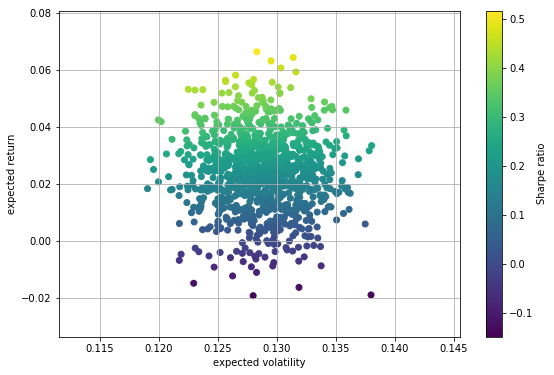

In [6]:
port_1 = get_port(close_1, 100)

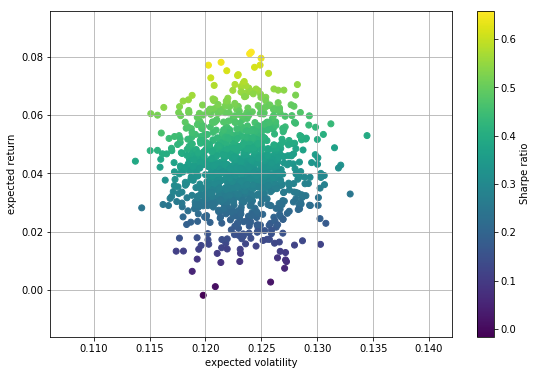

In [7]:
port_2 = get_port(close_2, 99)

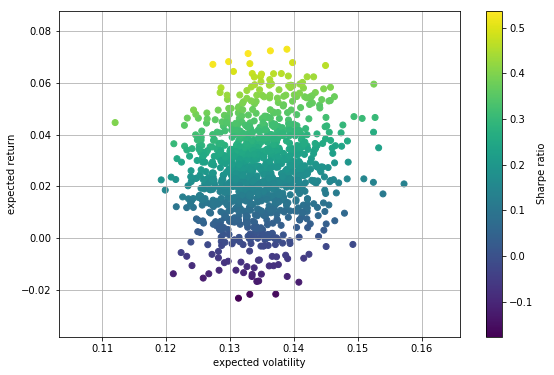

In [8]:
port_3 = get_port(close_3, 50)

### We already have 3 portfolios of securities, then we want to generate a whole portfolio by them

In [9]:
def set_new_assets(port, port_close,close,name):
    asset = np.array(port_close)
    new_assets = port * asset
    close[name] = pd.DataFrame(new_assets).apply(sum, axis = 1)

In [10]:
set_new_assets(port_1, close_1, close, 'port_1')
set_new_assets(port_2, close_2, close, 'port_2')
set_new_assets(port_3, close_3, close, 'port_3')

/Users/wen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [11]:
close_123 = close[['port_1', 'port_2', 'port_3']]

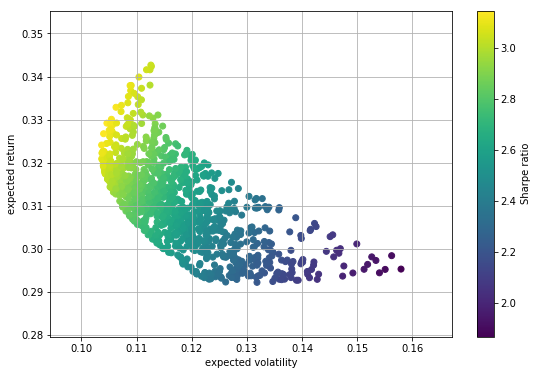

In [12]:
port_123 = get_port(close_123, 3)

In [13]:
def get_returns(port, close):
    log_returns = np.log(close/close.shift(1)) 
    rets = log_returns
    
    
    # use a function, when you input weights, the rate of return, votalities and sharpe ratio will be the output
    def calculations(weights):
        weights = np.array(weights)
        pret = np.sum(rets.mean()*weights)*252
        pvol = np.sqrt(np.dot(weights.T,np.dot(rets.cov()*252, weights)))
        return np.array([pret, pvol, pret/pvol])
    
    return calculations(port)

In [14]:
get_returns(port_123,close_123)

array([0.32980886, 0.10466288, 3.1511539 ])

### Conclusion

The average market performance is a return with yield to year end: 32.98% and volatility: 10.47%

# Initiate Securities object and Account object

In [15]:
"""
A class that performs as one kind of stocks
"""

class Securities:
#     class level attributes
    
#     Initialized with daily closed price
#     price and shares are the present price and shares to initialized
#     preprice in the price of previous period 
    def __init__(self, name: str, price, shares):
        self.price = price
        self.shares = shares
        self.name = name
        setattr(self, 'preprice', price) # automatically initiate preprice and preshares attributes to calculate gains from this stock
        setattr(self, 'preshares', shares)
        setattr(self, 'modify', 0) # .modify is the attibute that indicate shares to modify
        
    @property
    def price(self):
        return self._price
        
    @price.setter
    def price(self,price):
        if price < 0:
            raise ValueError("Price of securities cannot be negative")
        self._price = price
        
# -----------------------------------------------------------------------
# setting methods
    def reset(self, new_price, shares_to_modify):
        self.preshares = self.shares
        if shares_to_modify < 0:
            if -shares_to_modify > self.shares:
                raise ValueError('Can not sell more shares than you have')
            else:
                self.shares += shares_to_modify
        else:
            self.shares += shares_to_modify
        self.preprice = self.price
        self.price = new_price
        self.modify = shares_to_modify
        
#     .gains() returns the total gains(or losses) from selling(or buying) certain shares of stock at the present price
    def gains(self):
        if self.modify == 0:
            raise ValueError('None shares need to modify.')
        shares_to_modify = -self.modify
        self.modify = 0 # important! reset the .modify attribute to be 0
        return self.price * shares_to_modify

In [16]:
"""
A class that performs as a securities account
"""
class Account:
#     class level attributes
    INITCASH = 100000
    Tax = 0.25
    
#     stocks are one or several Securities objects
#     marval -- market value of the portfolio
    def __init__(self,*stocks):
        values = [*stocks] # portfoio of this account
        keys = [y.name for y in [*stocks]] # list of stocks' name in portfolio
        self.port = dict(zip(keys, values))
        marval = sum([y.price*y.shares for y in [*stocks]])
        if marval > self.INITCASH:
            raise ValueError('Cannot initiate account with total market value more than initial cash')
        else:
            setattr(self, 'cashleft', self.INITCASH - marval)
            setattr(self, 'cashpool', self.INITCASH - marval)
    
#     Attribute that prevent trading from going on when it encounters huge losses
    @property
    def cashleft(self):
        return self._cashleft
    
    @cashleft.setter
    def cashleft(self, cash):
        if cash < 0:
            raise ValueError('Cash in the account cannot be negative!')
        else:
            self._cashleft = cash
    
# -------------------------------------------------------------------------
# Start setting methods

#     update the market value in time
    @property
    def marval(self):
        marval = sum([x.price*x.shares for x in self.port.values()])
        return marval
    
    def __repr__(self):
        print("stock name | present price | present position")
        for stock_name in self.port.keys():
            print(f"{stock_name} \t\t {self.port[stock_name].price} \t\t {self.port[stock_name].shares}")
        return f'present market value: {self.marval}'
        
# The reallocation method will take a dict as input 
# The dict looks like {'AAPL':(10,0),'GOOGL':(12,100),'ORCL':(7.5,-100),...}, 
# keys of the dict are names of stocks to modify, for the dict-value tuple the first element is the new price and the second one is shares to modify
# The method has 3 functions:
#                             reset every Securities object that is to be modified
#                             calculate the gains and losses of the account
#                             calculate the yield of portfolio
    # adjusts is a list of daily shares and price adjustment
    def sell(self, adjusts: dict): 
        adjprice = dict(zip([x for x in adjusts.keys()], 
                            [y[0] for y in adjusts.values()]))
        adjshares = dict(zip([x for x in adjusts.keys()], 
                             [y[1] for y in adjusts.values()]))
        for adjust in adjshares.values():
            if adjust >= 0:
                raise ValueError('Shares to modify in the to-sell list must be negative!')
        for stock in adjusts.keys():
            if stock not in self.port.keys():
                raise ValueError('Illegal adjustment! Can not sell stocks not in the portfolio')

#          sell out all the stock in the to-sell list and cauculate gains
        for stock_name in adjusts.keys():
            new_price = adjprice[stock_name]
            shares_to_modify = adjshares[stock_name]
            stock = self.port[stock_name] # stock is a Securities object
            stock.reset(new_price, shares_to_modify)  # important command to reset stock
            gains = stock.gains()
#             This is the objective execution of this function 
            self.cashpool += gains # gains cash from selling stocks in the to-sell list
        soldout = list(stock for stock in self.port.values())
        for stock in soldout: # remove the stocks whose position have been closed from the portfolio
                if stock.shares == 0:
                    del self.port[stock.name]
        setattr(self, 'havesell', True)
    
    def buy(self, adjusts: dict):
        if not self.havesell:
            raise ValueError('You must sell some securities first obtaining some cash to support trading!')
        adjprice = dict(zip([x for x in adjusts.keys()], 
                            [y[0] for y in adjusts.values()]))
        adjshares = dict(zip([x for x in adjusts.keys()], 
                             [y[1] for y in adjusts.values()]))
        for stock_name in adjusts.keys():
            if adjshares[stock_name] <= 0:
                raise ValueError('Shares in the adjusts must be positive!')
            if stock_name not in self.port.keys():
                new_stock = Securities(stock_name, 
                                       adjprice[stock_name],
                                       0)
                self.port[stock_name] = new_stock
            stock = self.port[stock_name]
            new_price = adjprice[stock_name]
            modify = adjshares[stock_name]
            stock.reset(new_price, modify)
            gains = stock.gains()
            if self.cashpool + gains < 0:
                raise ValueError('Cannot use more money than cash pool!')
            self.cashpool += gains
        self.cashleft = self.cashpool
        self.havesell = False

# Alpaca Strategy

### Data preprocessing

In [43]:
def preprocess(df):
    global df_a
    df_a = df.copy()
    if df_a.isnull().values.any():
        raise ValueError('Exist NaN Value!')
    else:
        df_a.set_index('Date', inplace = True)

    #     create market value(Mkt) columns by price_column * volume_column

    #     first generate Mkt numpy arrays
        close = list()
        volume = list()
        for column in df_a.columns:
            pattern_C = r"[a-zA-Z-]+_Close$"
            pattern_V = r"[a-zA-Z-]+_Volume$"
            match_c = re.findall(pattern_C, column)
            match_v = re.findall(pattern_V, column)
            close += match_c
            volume += match_v

        for x in [*zip(close, volume)]:
            _close = x[0]
            _volume = x[1]
            name = _close.split("_")[0]
            df_a[name + "_Mkt"] = np.array(df_a[_close]) * np.array(df_a[_volume])

    #     then, generate Mkt columns using Mkt numpy arrays
        s = list() # s is the list of Mkt columns name
        for x in df_a.columns.tolist():
            p = r"[a-zA-Z-]+_Mkt$"
            match = re.findall(p,x)
            s += match

        small_ = df_a[s]
        small_np = np.array(small_)
        small_np = small_np.T
        small_df = pd.DataFrame(small_np, index=small_.columns.tolist(), columns=small_.index.tolist())
        global alpaca
        alpaca = small_df

In [44]:
preprocess(df)

In [32]:
def init_returns(alpaca): 
    ### create returns 
    columns = alpaca.columns.tolist()
    for i in columns[0:504]:
        index = columns.index(i)
        alpaca[str(i) + '_' + 'returns'] = (alpaca[alpaca.columns[index+1]] - alpaca[alpaca.columns[index]]) / alpaca[alpaca.columns[index]]
        returns = alpaca.iloc[:, 504:]# use market values to calculate returns every day
        returns.columns = [str(i).split("_")[0] for i in returns.columns.tolist()]
    return returns

In [33]:
returns = init_returns(alpaca)

### Initiate trading

In [35]:
### function to get the initial basket from date x ###
def initial_day(df, returns, x, cashpool, stocknum):
    position = returns.columns.tolist().index(x) # get the column index of the date x input
    returns = returns.sort_values([x],ascending=False) # sort according to date x
    choice = np.array(returns.index[0:stocknum]).tolist() # get the smallest N(5) stocks of the day
    choice = [i.split('_')[0] for i in choice]

    # get the column name I want to find the close price for each stock on day x
    price = [i.split('_')[0] + "_" + 'Close' for i in choice]

    # find the close price for each stock on day x
    close = []
    for i in range(len(price)):
        b = df.loc[x, price[i]]
        close.append(b)
        invest = cashpool / stocknum
        share = [int(invest / i) for i in close]
        buy_dict = dict(zip(choice, share)) # update buy_list for INITIAL day x
    return buy_dict

In [36]:
# Switch the format of function: initial_day and second_day
# original format is {stock_name: shares_to_adjust}
# updated format is {stock_name: (present_price, shares_to_adjust)}
def transform(df, adjdict, date):
    output = dict()
    for stock_name in adjdict.keys():
        column = stock_name + "_Close"
        price = df.loc[date, column]
        output_value = (price, adjdict[stock_name])
        output[stock_name] = output_value
    return output

In [37]:
# initiate Securities Object and Account Object
def initiate(init_dict):
    prepare_for_account = dict()
    
#     initiate all stocks
    for stock_name in init_dict.keys():
        prepare_for_account[stock_name] = Securities(stock_name,
                                                     init_dict[stock_name][0],
                                                     init_dict[stock_name][1])
#         initiate the stocks account
    account = Account(*prepare_for_account.values())
    return account

In [38]:
def reallocation(account, df, returns, y): # date x -- enter stock market; y- date want to make change
    buy_dict = dict()
    
#     munipulate date time
    date_list = df.index.tolist()
    delta = datetime.timedelta(days = 1)
    today = datetime.datetime.strptime(y,'%Y-%m-%d')
    delta = datetime.timedelta(days = 1)
    x = datetime.date.strftime(today - delta, "%Y-%m-%d")
    while x not in date_list:
        x_day = datetime.datetime.strptime(x,'%Y-%m-%d')
        x = datetime.date.strftime(x_day - delta, "%Y-%m-%d")
    
    position = returns.columns.tolist().index(x) # get the column index of the date x input
    returns1 = returns.sort_values([x],ascending=False) # sort according to date x
    choice = np.array(returns1.index[0:30]).tolist() # get the smallest N(30) stocks of the day
    choice = [i.split('_')[0] for i in choice] # stock_name list of the least 30 market value 
    for name in choice:
        if name not in account.port.keys():
            raise ValueError("Portfolio in the previous trading day is not in accordance with the Account object, You might have skipped some dates.")
    
    def new_basket(returns, y): # given day y - that we want to get portfolio change
        position = returns.columns.tolist().index(y) # get the column index of second day of the date x input
        returns2 = returns.sort_values([y],ascending=False) # sort according to date x
        choice2 = np.array(returns2.index[0:30]).tolist() # get the smallest N(5) stocks of the second day
        choice2 = [i.split('_')[0] for i in choice2]
        ones = np.ones(30, dtype=int) # give all 1 to  to buy for each stock
        a = dict(zip(choice2, ones)) # buy basket for date y
        return a

    ### FINALIZED 3 dicts to return at the end ###
    new = new_basket(returns,y) #today
    sell = dict()
    keep = dict()
    buy = dict()
    for name in new:
        if name not in choice:
            buy[name] = 1
        else:
            keep[name] = 0
    for name in choice:
        if name not in new.keys():
            sell[name] = -account.port[name].shares

    return (buy, keep, sell)

In [39]:
def pretrade(df,buy,cash,date):
    import random
    long = buy
    assert len(long) < 30 # the securities pool of this strategy is 30
    percash = cash/len(long)
    for stock_name in long:
        price = df.loc[date, stock_name+"_Close"]
        long[stock_name] = (price, round(percash/price))
    if sum([*zip(*long.values())][1]) > cash: # this sum function computes the total present value after rounding
        stock_name = [*long.keys()][random.randint(0,len(long)-1)]
        long[stock_name] = (long[stock_name][0], long[stock_name][1]-1) # randomly select one stock and subtract 1 from its shares
    return long

In [40]:
def keepposition(df,keep,date,account):
    for stock_name in keep:
        if stock_name not in account.port:
            raise ValueError('Keep list is not in accordance with present portfolio!')
        column = stock_name + "_Close"
        price = df.loc[date, column]
        stock = account.port[stock_name]
        stock.reset(price, 0)

In [46]:
def trading(df,returns):
    initial = initial_day(df, returns, '2016-11-21', 100000, 30)
    init_basket = transform(df,initial,'2016-11-21')
    account = initiate(init_basket)
    pv_ = list()
    
    for date in df.index.tolist()[1:]: #exceping the initial date
        buy, keep, sell = reallocation(account, df, returns, date) 
        sell_dict = transform(df,sell,date)
        buy_dict = transform(df,buy,date)
        account.sell(sell_dict)
        account.buy(buy_dict)
        keepposition(df,keep,date,account)
        value = account.marval + account.cashleft
        pv_.append(value)
    
    pv = account.marval + account.cashleft
    
    return pv, pv_

In [48]:
pv_a, pv_a_list = trading(df_a, returns)

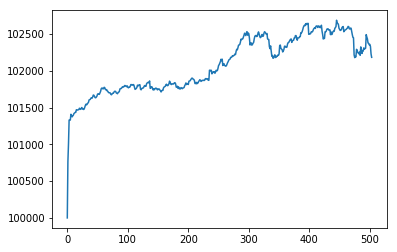

In [49]:
pv_a_list.insert(0,100000)
df['total_pv_a'] = pv_a_list
yield_a_curve = df['total_pv_a'].plot(x=df_a.index, kind='line')

# Small-Cap model

### Preprocessing

In [50]:
def preprocess(df):
    if df.isnull().values.any():
        raise ValueError('Exist NaN Value!')
    else:
        df.set_index('Date', inplace = True)

    #     create market value(Mkt) columns by price_column * volume_column

    #     first generate Mkt numpy arrays
        close = list()
        volume = list()
        for column in df.columns:
            pattern_C = r"[a-zA-Z-]+_Close$"
            pattern_V = r"[a-zA-Z-]+_Volume$"
            match_c = re.findall(pattern_C, column)
            match_v = re.findall(pattern_V, column)
            close += match_c
            volume += match_v

        for x in [*zip(close, volume)]:
            _close = x[0]
            _volume = x[1]
            name = _close.split("_")[0]
            df[name + "_Mkt"] = np.array(df[_close]) * np.array(df[_volume])

    #     then, generate Mkt columns using Mkt numpy arrays
        s = list() # s is the list of Mkt columns name
        for x in df.columns.tolist():
            p = r"[a-zA-Z-]+_Mkt$"
            match = re.findall(p,x)
            s += match

        small_ = df[s]
        small_np = np.array(small_)
        small_np = small_np.T
        small_df = pd.DataFrame(small_np, index=small_.columns.tolist(), columns=small_.index.tolist())
        global small
        small = small_df

In [51]:
preprocess(df)

### Initiate Trading

In [52]:
### function to get the initial basket from date x ###
def initial_day(df, small, x, cashpool, stocknum):
    position = small.columns.tolist().index(x) # get the column index of the date x input
    small1 = small.sort_values([x]) # sort according to date x
    choice = np.array(small1.index[0:stocknum]).tolist() # get the smallest N(5) stocks of the day
    choice = [i.split('_')[0] for i in choice]

    # get the column name I want to find the close price for each stock on day x
    price = [i.split('_')[0] + "_" + 'Close' for i in choice]

    # find the close price for each stock on day x
    close = []
    for i in range(len(price)):
        b = df.loc[x, price[i]]
        close.append(b)
        invest = cashpool / stocknum
        share = [int(invest / i) for i in close]
        buy_dict = dict(zip(choice, share)) # update buy_list for INITIAL day x
    return buy_dict

In [53]:
# Switch the format of function: initial_day and second_day
# original format is {stock_name: shares_to_adjust}
# updated format is {stock_name: (present_price, shares_to_adjust)}
def transform(df, adjdict, date):
    output = dict()
    for stock_name in adjdict.keys():
        column = stock_name + "_Close"
        price = df.loc[date, column]
        output_value = (price, adjdict[stock_name])
        output[stock_name] = output_value
    return output

In [54]:
# initiate Securities Object and Account Object
def initiate(init_dict):
    prepare_for_account = dict()
    
#     initiate all stocks
    for stock_name in init_dict.keys():
        prepare_for_account[stock_name] = Securities(stock_name,
                                                     init_dict[stock_name][0],
                                                     init_dict[stock_name][1])
#         initiate the stocks account
    account = Account(*prepare_for_account.values())
    return account

### Reallocate assets given trade date and present portfolio

In [55]:
def reallocation(account, df, small, y): # date x -- enter stock market; y- date want to make change
    buy_dict = dict()
    
#     munipulate date time
    date_list = df.index.tolist()
    delta = datetime.timedelta(days = 1)
    today = datetime.datetime.strptime(y,'%Y-%m-%d')
    delta = datetime.timedelta(days = 1)
    x = datetime.date.strftime(today - delta, "%Y-%m-%d")
    while x not in date_list:
        x_day = datetime.datetime.strptime(x,'%Y-%m-%d')
        x = datetime.date.strftime(x_day - delta, "%Y-%m-%d")
    
    position = small.columns.tolist().index(x) # get the column index of the date x input
    small1 = small.sort_values([x]) # sort according to date x
    choice = np.array(small1.index[0:30]).tolist() # get the smallest N(30) stocks of the day
    choice = [i.split('_')[0] for i in choice] # stock_name list of the least 30 market value 
    for name in choice:
        if name not in account.port.keys():
            raise ValueError("Portfolio in the previous trading day is not in accordance with the Account object, You might have skipped some dates.")
    
    def new_basket(small, y): # given day y - that we want to get portfolio change
        position = small.columns.tolist().index(y) # get the column index of second day of the date x input
        small2 = small.sort_values([y]) # sort according to date x
        choice2 = np.array(small2.index[0:30]).tolist() # get the smallest N(5) stocks of the second day
        choice2 = [i.split('_')[0] for i in choice2]
        ones = np.ones(30, dtype=int) # give all 1 to  to buy for each stock
        a = dict(zip(choice2, ones)) # buy basket for date y
        return a

    ### FINALIZED 3 dicts to return at the end ###
    new = new_basket(small,y) #today
    sell = dict()
    keep = dict()
    buy = dict()
    for name in new:
        if name not in choice:
            buy[name] = 1
        else:
            keep[name] = 0
    for name in choice:
        if name not in new.keys():
            sell[name] = -account.port[name].shares

    return (buy, keep, sell)

### Given a buy list return a buy dict that can be passed into .buy method

In [56]:
def pretrade(df,buy,cash,date):
    import random
    long = buy
    assert len(long) < 30 # the securities pool of this strategy is 30
    percash = cash/len(long)
    for stock_name in long:
        price = df.loc[date, stock_name+"_Close"]
        long[stock_name] = (price, round(percash/price))
    if sum([*zip(*long.values())][1]) > cash: # this sum function computes the total present value after rounding
        stock_name = [*long.keys()][random.randint(0,len(long)-1)]
        long[stock_name] = (long[stock_name][0], long[stock_name][1]-1) # randomly select one stock and subtract 1 from its shares
    return long

### reset the price of stocks that kept position

In [57]:
def keepposition(df,keep,date,account):
    for stock_name in keep:
        if stock_name not in account.port:
            raise ValueError('Keep list is not in accordance with present portfolio!')
        column = stock_name + "_Close"
        price = df.loc[date, column]
        stock = account.port[stock_name]
        stock.reset(price, 0)

### Begin the whole trading now!

In [58]:
def trading(df,small):
    initial = initial_day(df, small, '2016-11-21', 100000, 30)
    init_basket = transform(df,initial,'2016-11-21')
    account = initiate(init_basket)
    pv_ = list()
    
    for date in df.index.tolist()[1:]: #exceping the initial date
        buy, keep, sell = reallocation(account, df, small, date) 
        sell_dict = transform(df,sell,date)
        buy_dict = transform(df,buy,date)
        account.sell(sell_dict)
        account.buy(buy_dict)
        keepposition(df,keep,date,account)
        value = account.marval + account.cashleft
        pv_.append(value)
    
    pv = account.marval + account.cashleft
    
    return pv, pv_

In [59]:
pv, pv_list = trading(df, small)

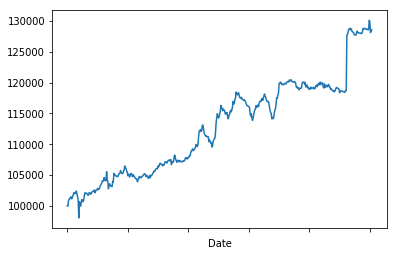

In [60]:
pv_list.insert(0,100000)
df['total_pv'] = pv_list
yield_curve = df['total_pv'].plot(x=df.index, kind='line')